In [18]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle

import matplotlib.pyplot as plt


import pandas as pd
import pickle
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix

In [2]:
# Reading in the cleaned dataset
delay_df = pd.read_pickle("combined_flight_data")

In [5]:
# Extracting target delay data column from the dataset
delayed = delay_df[['ArrDel15']]
delay_df = delay_df.drop("ArrDel15",axis=1)

In [9]:
# Defining relevant columns and trimming the dataset down to relevant columns
relevant_flight_cols = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Distance',
                        'Origin', 'OriginCityName', 'OriginStateName', 'OriginCityMarketID',
                        'Dest', 'DestCityName', 'DestStateName', 'DestCityMarketID'
                        #,'Reporting_Airline', 'ActualElapsedTime', 'AirTime'
                        ]
relevant_weather_cols = ['temp', 'dewPt', 'wspd', 'pressure', 'precip_hrly']
relevant_columns = relevant_flight_cols + relevant_weather_cols
delay_df = delay_df[relevant_columns]

#### To-Do

* Revise dataset to include 'Reporting_Airline'

In [10]:
delay_df.columns.tolist()

['Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'Distance',
 'Origin',
 'OriginCityName',
 'OriginStateName',
 'OriginCityMarketID',
 'Dest',
 'DestCityName',
 'DestStateName',
 'DestCityMarketID',
 'temp',
 'dewPt',
 'wspd',
 'pressure',
 'precip_hrly']

In [11]:
# Converting ID numbers to categorical string data
delay_df.OriginCityMarketID = delay_df.OriginCityMarketID.astype(str)
delay_df.DestCityMarketID = delay_df.DestCityMarketID.astype(str)

C:\Users\bruno\AppData\Local\Temp\ipykernel_31624\1134623195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_df.OriginCityMarketID = delay_df.OriginCityMarketID.astype(str)
C:\Users\bruno\AppData\Local\Temp\ipykernel_31624\1134623195.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_df.DestCityMarketID = delay_df.DestCityMarketID.astype(str)


In [12]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(delay_df, delayed, stratify=delayed)

In [13]:
# Recording which columns are numeric and which are categorical
numeric_cols = X_train.dtypes[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')].index.tolist()
non_numeric_cols = X_train.dtypes[(X_train.dtypes != 'int64') & (X_train.dtypes != 'float64')].index.tolist()

In [14]:
# Creating a transformer object to scale numeric data and encode categorical data
encoder = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_cols),
    ('one_hot', OneHotEncoder(drop='first', handle_unknown='ignore'), non_numeric_cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [15]:
# Applying pre-processing transformations
encoder.fit(X_train)
X_train_sparse = encoder.transform(X_train)
X_train_columns = encoder.get_feature_names_out()
X_test_sparse = encoder.transform(X_test)
X_test_columns = encoder.get_feature_names_out()

**In case of too much data, break glass:**

# Extracting a representative sample from the dataset
training_set_samples = np.random.choice(X_train_sparse.shape[0], X_train_sparse.shape[0]//100, replace=False)
X_train_sparse = X_train_sparse[training_set_samples, :]
y_train = y_train.reset_index().drop('index',axis=1).loc[training_set_samples.tolist()]['ArrDel15']

In [16]:
# Displaying the baseline classifier accuracy
y_train.value_counts(normalize=True)

ArrDel15
0.0         0.837106
1.0         0.162894
Name: proportion, dtype: float64

In [21]:
# Defining logistic regression parameters to sweep over
logreg_params = {
    'penalty':['l1','l2'],
    'C':[0.1,1,10]
}
# GridSearching logistic regression classifiers
logreg_grid = GridSearchCV(LogisticRegression(solver='liblinear'), logreg_params, n_jobs=-2)
logreg_grid.fit(X_train_sparse, np.ravel(y_train))
# Printing out train and test accuracy scores
print(f'Training accuracy: {logreg_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {logreg_grid.score(X_test_sparse, y_test)}')

Training accuracy: 0.8371056480256285
Testing accuracy: 0.8370587006475873


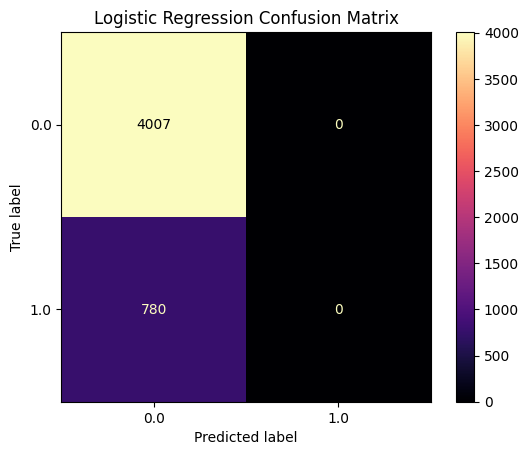

In [22]:
ConfusionMatrixDisplay.from_estimator(logreg_grid, X_test_sparse, y_test, cmap='magma');
plt.title('Logistic Regression Confusion Matrix');

In [23]:
# Defining random forest parameters to sweep over
rfc_params = {
    'n_estimators':[100,1000],
    'max_depth':[100,1000],
    'ccp_alpha':[0, 0.1]
}
# GridSearching random forest classifiers
rfc_grid = GridSearchCV(RandomForestClassifier(), rfc_params, n_jobs=-2)
rfc_grid.fit(X_train_sparse, y_train)
# Displaying train and test scores
print(f'Training accuracy: {rfc_grid.score(X_train_sparse, y_train)}')
print(f'Testing accuracy: {rfc_grid.score(X_test_sparse, y_test)}')

C:\Users\bruno\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training accuracy: 0.8371056480256285
Testing accuracy: 0.8370587006475873


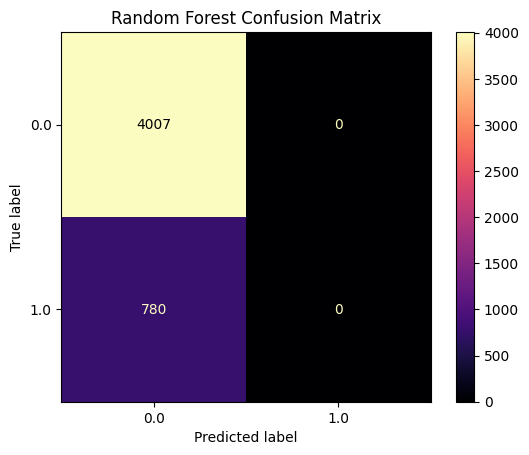

In [24]:
ConfusionMatrixDisplay.from_estimator(rfc_grid, X_test_sparse, y_test, cmap='magma');
plt.title('Random Forest Confusion Matrix');